Using the constrcuted dataset to test out the NIPS debiasing method

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

DATA_ROOT = Path("../data")

In [4]:
from bert_utils import Config, BertPreprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [6]:
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    subspace_size=5,
)

In [7]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [8]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

In [9]:
from dataclasses import dataclass

@dataclass
class ContextWord:
    sent: str
    word: str
    def __post_init__(self):
        assert self.word in self.sent

In [10]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [11]:
def get_word_vector(cword: ContextWord, use_last_mask=False):
    sentence, word = cword.sent, cword.word
    idx = processor.get_index(sentence, word, last=use_last_mask)
    outputs = None
    with torch.no_grad():
        # TODO: Move to proper library function
        token_ids = processor.to_bert_model_input(sentence) 
        # ensure padding is consistent
        bert_input = torch.zeros(1, config.max_seq_len, dtype=torch.long)
        bert_input[0, :token_ids.size(1)] = token_ids
        sequence_output, _ = model.bert(bert_input,
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
        if outputs is None: outputs = torch.zeros_like(sequence_output)
        outputs = sequence_output + outputs
    return outputs.detach().cpu().numpy()[idx]

In [12]:
def construct_sim_matrix(vecs):
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v in enumerate(vecs):
        for j, w in enumerate(vecs):
            sim_matrix[i, j] = cosine_similarity(v, w)
    return sim_matrix

In [13]:
def construct_sim_matrix_df(sentences: List[str],
                           words: List[str]):
    sim = construct_sim_matrix([get_word_vector(ContextWord(sent, word)) for sent, word in zip(sentences, words)])
    return pd.DataFrame(data=sim, index=words, columns=words)

In [14]:
def compute_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(get_word_vector(cword11) - get_word_vector(cword12),
                             get_word_vector(cword21) - get_word_vector(cword22))

In [15]:
out_softmax = model.cls.predictions.decoder.weight.data.cpu().numpy()

In [16]:
out_bias = model.cls.predictions.bias.data.cpu().numpy()

In [17]:
def to_logits(wv: np.ndarray) -> np.ndarray:
    return model.cls(torch.FloatTensor(wv).unsqueeze(0)).detach().cpu().numpy()[0, :]

# Check similarities

In [18]:
construct_sim_matrix_df(["That person is a programmer.", 
                         "I am a man.", 
                         "I am a woman."],
                       ["programmer", "man", "woman"])

,programmer,man,woman
programmer,1.000000,0.453046,0.488973
man,0.453046,1.000000,0.781821
woman,0.488973,0.781821,1.000000


In [19]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.13653895

In [20]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.20923696

In [21]:
compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.21795174

# Find gendered direction

In [22]:
df_train = pd.read_csv(DATA_ROOT / train_file)

In [23]:
df_val = pd.read_csv(DATA_ROOT / val_file)

In [24]:
from tqdm import tqdm

male_vecs, female_vecs = [], []
def add_word_vecs(s: str, male_w: str, female_w: str):
    male_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", male_w), male_w)))
    female_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", female_w), female_w)))

for i, row in tqdm(list(df_train.iterrows())):
    sentence = row["sentence"]
    add_word_vecs(sentence, row["mword"], row["fword"])

100%|██████████| 2484/2484 [08:23<00:00,  4.77it/s]


In [25]:
male_vecs = np.r_[male_vecs]
female_vecs = np.r_[female_vecs]

In [26]:
from sklearn.decomposition import PCA
def find_subspace(D: np.ndarray) -> PCA:
    assert len(D.shape) == 2
    pca = PCA(n_components=config.subspace_size)
    return pca.fit(D)

In [27]:
pca = find_subspace(male_vecs - female_vecs)

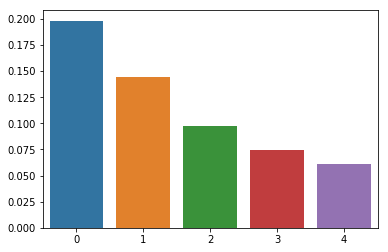

In [28]:
sns.barplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)

This is what it says in the paper

We denote the projection of a vector $ v $ onto $ B $ by

$$ v_B = \sum_{j=1}^{k} (v \cdot b_j) b_j $$

For each word $ w \in N $, let $ \vec{w} $ be re-embedded to
$$ \vec{w} := \vec{w} - \vec{w_{B}} / || \vec{w} - \vec{w_{B}} || $$

$$ \mu := \sum_{w \in E}w / |E| $$
$$ \nu := \mu - \mu_B $$
For each $ w \in E $, 
$$ \vec{w} := \nu + \sqrt{1 - ||\nu||^2}\frac{\vec{w_B} - \mu_B}{||\vec{w_B} - \mu_B||} $$

In [29]:
def remove_subspace(X: np.ndarray, subspace: np.ndarray, norm=True) -> np.ndarray:
    Xb = ((X @ subspace.T) @ subspace) # projection onto biased subspace
    X = (X - Xb) / (np.linalg.norm(X - Xb))
    if norm:
        mu = X.mean(0)
        mub = Xb.mean(0)
        nu = mu - mub
        return nu + np.sqrt(1 - nu**2) * (Xb - mub) / np.linalg.norm(Xb - mub)
    else:
        return X

In [30]:
remove_subspace(male_vecs, pca.components_)

array([[ 0.04787444, -0.02169324, -0.00895408, ..., -0.02797836,
        -0.11689992,  0.02905806],
       [ 0.04798546, -0.02343445, -0.00885439, ..., -0.02715371,
        -0.11659659,  0.03071715],
       [ 0.04853043, -0.02295981, -0.00920405, ..., -0.02754682,
        -0.11671596,  0.03101385],
       ...,
       [ 0.04892976, -0.02380815, -0.0097078 , ..., -0.02796934,
        -0.11877806,  0.03163356],
       [ 0.04910754, -0.02278174, -0.01037116, ..., -0.02844698,
        -0.11777176,  0.03153326],
       [ 0.04890153, -0.02371617, -0.00993423, ..., -0.02800499,
        -0.11829869,  0.03171503]], dtype=float32)

### Newly checking for differences

In [31]:
def pp(X: np.ndarray) -> np.ndarray:
    """Postprocess"""
    return remove_subspace(np.expand_dims(X, 0), pca.components_, norm=False)[0]

In [32]:
def compute_new_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(pp(get_word_vector(cword11)) - pp(get_word_vector(cword12)),
                             pp(get_word_vector(cword21)) - pp(get_word_vector(cword22)))

Similarities are being reduced, so there is a shared gender subspace to a certain extent.

In [33]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.13653895, 0.037773743)

In [34]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.20923696, 0.1354464)

In [35]:
(compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.21795174, 0.16982587)

# Checking for change in bias score

Let's see if the bias score decreases with this transformation

In [36]:
def compute_postprocess_bias_score(row):
    sentence, mword, fword, prior_bias = (row["sentence"], row["mword"], 
                                          row["fword"], row["prior_bias"])
    mwi, fwi = processor.token_to_index(mword), processor.token_to_index(fword)
    wv = get_word_vector(
        ContextWord(sentence, "[MASK]"),
        use_last_mask=True,
    )
    wv = pp(wv)
    logits = to_logits(wv)
    subject_fill_bias = logits[fwi] - logits[mwi]
    return subject_fill_bias - prior_bias

Bias is reduced here

In [37]:
tqdm.pandas()
df_train["bias_score_after"] = df_train.progress_apply(compute_postprocess_bias_score, axis=1)

100%|██████████| 2484/2484 [05:19<00:00,  6.32it/s]


(array([ 21.,  75., 180., 502., 721., 611., 289.,  75.,   6.,   4.]),
 array([-2.44384933, -1.99285557, -1.54186182, -1.09086807, -0.63987432,
        -0.18888056,  0.26211319,  0.71310694,  1.16410069,  1.61509445,
         2.0660882 ]),
 <a list of 10 Patch objects>)

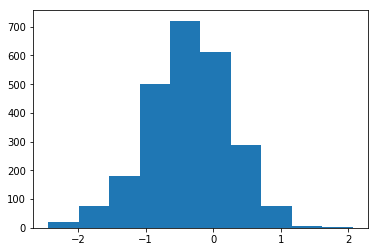

In [38]:
plt.hist(df_train["original_bias_score"])

In [39]:
df_train["original_bias_score"].abs().mean()

0.5631442379398383

In [40]:
df_train["bias_score_after"].abs().mean()

0.6150368443673744

The bias score does not seem to be evenly reduced

(array([207.,   0.,  10., 474., 324., 226., 509., 184., 329., 221.]),
 array([-1.35968554, -1.08596485, -0.81224415, -0.53852346, -0.26480277,
         0.00891793,  0.28263862,  0.55635931,  0.83008001,  1.1038007 ,
         1.3775214 ]),
 <a list of 10 Patch objects>)

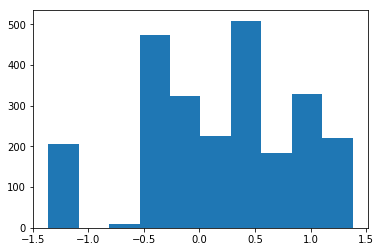

In [41]:
plt.hist(df_train["bias_score_after"])

In [42]:
df_train[df_train["bias_score_after"].abs() > df_train["original_bias_score"].abs()]

,sentence,fword,mword,target,p1,p2,prior_bias,original_bias_score,bias_score_after
0,[MASK] is accessible,she,he,accessible,4.865298e-03,0.012277,-1.501020,0.575404,0.834443
1,[MASK] is accessible,her,him,accessible,1.059399e-04,0.000095,-0.201257,0.307921,0.518240
2,[MASK] is accessible,woman,man,accessible,6.379329e-06,0.000050,-1.737486,-0.312989,1.021986
3,[MASK] is accessible,girl,boy,accessible,2.258840e-05,0.000023,0.006741,-0.036383,0.422076
4,[MASK] is accessible,sister,brother,accessible,3.628622e-06,0.000004,-0.069847,0.045879,-0.048475
5,[MASK] is accessible,daughter,son,accessible,3.038641e-06,0.000004,0.013902,-0.328705,-0.467730
6,[MASK] is accessible,wife,husband,accessible,2.532225e-06,0.000002,0.111183,0.140979,0.500705
7,[MASK] is accessible,girlfriend,boyfriend,accessible,3.096659e-06,0.000005,-1.249217,0.854755,1.340076
8,[MASK] is accessible,mother,father,accessible,2.404686e-05,0.000015,0.676304,-0.222323,-0.456434
11,[MASK] is accessible,grandmother,grandfather,accessible,1.587222e-05,0.000003,0.719977,0.909298,-1.236488


Evaluation on the validation set

In [43]:
df_val["bias_score_after"] = df_val.progress_apply(compute_postprocess_bias_score, axis=1)

100%|██████████| 276/276 [00:39<00:00,  7.03it/s]


(array([ 1.,  4.,  4., 11., 38., 63., 66., 56., 29.,  4.]),
 array([-2.98104119, -2.5734925 , -2.16594381, -1.75839512, -1.35084643,
        -0.94329774, -0.53574905, -0.12820036,  0.27934833,  0.68689702,
         1.09444571]),
 <a list of 10 Patch objects>)

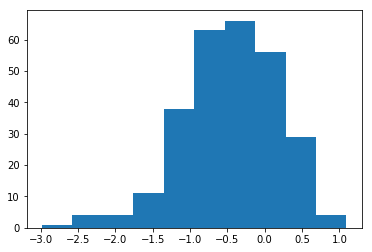

In [44]:
plt.hist(df_val["original_bias_score"])

(array([23.,  0.,  2., 54., 35., 24., 52., 25., 36., 25.]),
 array([-1.34195364, -1.0717145 , -0.80147536, -0.53123622, -0.26099708,
         0.00924206,  0.2794812 ,  0.54972034,  0.81995947,  1.09019861,
         1.36043775]),
 <a list of 10 Patch objects>)

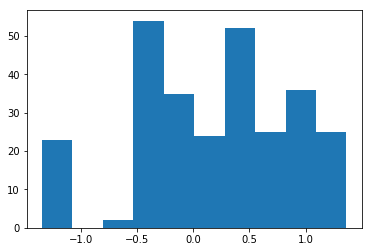

In [45]:
plt.hist(df_val["bias_score_after"])

In [46]:
df_val["original_bias_score"].abs().mean()

0.6147687844932079

In [47]:
df_val["bias_score_after"].abs().mean()

0.6126800814400548

# Unintended Side Effects

Are there any unintended side effects of this transformation? Let's test and see

In [48]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The doctor went to the office.", "doctor"))
)

-0.05279458

In [49]:
 def construct_sim_matrix_df(cws: List[ContextWord]):
    return pd.DataFrame(data=sim, index=words, columns=words)

Before processing:

In [50]:
cws = [
    ContextWord("The programmer went to the office.", "programmer"),
    ContextWord("The doctor went to the office.", "doctor"),
    ContextWord("The nurse went to the office.", "nurse"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.736333,0.710306
doctor,0.736333,1.000000,0.758742
nurse,0.710306,0.758742,1.000000


After processing:

In [51]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.740371,0.715518
doctor,0.740371,1.000000,0.763563
nurse,0.715518,0.763563,1.000000


Interestingly, the similarities here seem to be roughly preserved; perhaps because we are neutralizing w.r.t to the gender dimension in the subject space, but not the object space?

In [52]:
cws = [
    ContextWord("Your colleague is very beautiful.", "beautiful"),
    ContextWord("Your colleague is very dangerous.", "dangerous"),
    ContextWord("Your colleague is very normal.", "normal"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.641661,0.568179
dangerous,0.641661,1.000000,0.568495
normal,0.568179,0.568495,1.000000


Again, not much reduction in similarities here...

In [53]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.657240,0.567063
dangerous,0.657240,1.000000,0.562291
normal,0.567063,0.562291,1.000000
